In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.layers import Dense, Activation
from keras import regularizers
from itertools import product
import tensorflow as tf
import keras as ke
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

/Users/theodiamandis/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
load_dir = "assets/car-rocket-ship/imnet_nofc/VGG19/128x128/"
X_train = np.load(load_dir + 'X_train.npy')
y_train = np.load(load_dir + 'y_train.npy')
X_test = np.load(load_dir + 'X_test.npy')
y_test = np.load(load_dir + 'y_test.npy')
N_tr = X_train.shape[0]
N_te = X_test.shape[0]
X_train = X_train.reshape(N_tr,-1)
X_test = X_test.reshape(N_te,-1)
in_size = X_train.shape[1]

In [3]:
reg=0.001
model_select = 1
if model_select is 0:
    model = Sequential([
        Dense(100,input_shape=(in_size,),kernel_regularizer=regularizers.l2(reg)),
        Activation('relu'),
        Dropout(0.3),
        Dense(50,kernel_regularizer=regularizers.l2(reg)),
        Activation('relu'),
        Dropout(0.3),
        Dense(3,kernel_regularizer=regularizers.l2(reg)),
        Activation('softmax')
        ])
if model_select is 1:
    model = Sequential([
        Dense(3,input_shape=(in_size,),kernel_regularizer=regularizers.l2(0.001)),
        Activation('softmax')
        ])

if model_select is 2:
    model = Sequential([
        #Dropout(0,input_shape=(in_size,)),
        Dense(10,input_shape=(in_size,),kernel_regularizer=regularizers.l2(0.5)),
        Activation('relu'),
        Dense(3,kernel_regularizer=regularizers.l2(reg)),
        Activation('softmax')
        ])

model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

Train on 600 samples, validate on 600 samples
Epoch 1/15
 - 0s - loss: 1.2090 - acc: 0.3500 - val_loss: 1.0940 - val_acc: 0.3483
Epoch 2/15
 - 0s - loss: 0.8961 - acc: 0.5933 - val_loss: 0.8005 - val_acc: 0.6950
Epoch 3/15
 - 0s - loss: 0.6639 - acc: 0.7850 - val_loss: 0.6522 - val_acc: 0.7350
Epoch 4/15
 - 0s - loss: 0.5574 - acc: 0.7967 - val_loss: 0.5397 - val_acc: 0.8167
Epoch 5/15
 - 0s - loss: 0.5185 - acc: 0.7950 - val_loss: 0.5567 - val_acc: 0.8000
Epoch 6/15
 - 0s - loss: 0.4606 - acc: 0.8217 - val_loss: 0.4936 - val_acc: 0.8150
Epoch 7/15
 - 0s - loss: 0.3955 - acc: 0.8700 - val_loss: 0.4493 - val_acc: 0.8400
Epoch 8/15
 - 0s - loss: 0.3706 - acc: 0.8817 - val_loss: 0.4457 - val_acc: 0.8500
Epoch 9/15
 - 0s - loss: 0.3525 - acc: 0.8850 - val_loss: 0.4125 - val_acc: 0.8450
Epoch 10/15
 - 0s - loss: 0.3380 - acc: 0.8850 - val_loss: 0.4064 - val_acc: 0.8617
Epoch 11/15
 - 0s - loss: 0.3222 - acc: 0.8883 - val_loss: 0.3968 - val_acc: 0.8600
Epoch 12/15
 - 0s - loss: 0.3157 - acc:

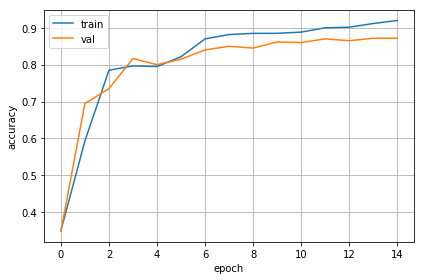

In [4]:
# Train the model and plot training info

hist = model.fit(X_train,y_train,
    validation_data=(X_test,y_test),
    batch_size = 100,
    epochs=15,
    verbose=2
    )
plt.plot(hist.history['acc'], label="train")
plt.plot(hist.history['val_acc'], label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [5]:
def weights_grad(X,model):
    N = X.shape[0]
    M = model.output.shape[1]
    w = model.trainable_weights
    out = model.layers[-2].output 
    grads = []
    for i in range(N): #iterate over the batch
        for j in range(M): #iterate over class score
            grads.append(k.gradients(out[i,j],w))
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    grads_evaled = sess.run(grads,feed_dict={model.input:X})
    # grads_evaled is is an M*N list of the gradients of the weights.
    # each element of this list in another list, that will be something like
    # [W1_grad, b1_grad, W2_grad, b2_grad ...]
    
    scores = sess.run(out,feed_dict={model.input:X})
    weights = sess.run(w,feed_dict={model.input:X})
    sess.close()
    return grads_evaled, scores, weights

In [6]:
batch_size = 2
indices = np.random.choice(range(N_tr), batch_size, replace=True)
X_batch = X_train[indices]
print(X_batch.shape)
grads, scores, weights = weights_grad(X_batch,model)

(2, 8192)


In [7]:
print(scores.shape)
print(len(weights))
print(weights[0].shape)

(2, 3)
2
(8192, 3)


In [8]:
##  processing testing
num_params = len(grads[0])
num_classes = 3
# score_grads = [None]*num_classes
# for score_ind in range(num_classes):
#     score_grads[score_ind] = [np.zeros_like(grads[0][param]) for param in range(num_params)]

# # Sum gradidents across the batch
# for ii in range(batch_size):
#     for param_ind, class_ind in product(range(num_params),range(num_classes)) :
#         score_grads[class_ind][param_ind] += grads[3*ii + class_ind][param_ind]

# Make big weight vector for each of the scores
# num_weights = in_size*10+10+10*3+3
num_weights = in_size*3+3
for nn in range(batch_size):
    g = np.zeros((num_weights,3))
    for class_ind in range(num_classes):
        g[:,[class_ind]] = np.vstack([param.reshape(-1,1) for param in grads[3*nn + class_ind]])
#         for param_ind in range(num_params):
#             np.vstack((gc, grads[3*nn + class_ind][param_ind].reshape(-1,1)))
#          = gc
print(g.shape)

ytrain_inds = y_train.argmax(axis=1)
print(y_train[indices].shape)
print(ytrain_inds[indices].shape)
print(indices.shape)
print(y_train[0:10])
print(ytrain_inds[0:10])

wk = np.vstack([param.reshape(-1,1) for param in weights])
print(wk.shape)
print(len(weights))
print(weights[0].shape)
# print(np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))

(24579, 3)
(2, 3)
(2,)
(2,)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
[2 0 2 0 0 2 1 2 2 0]
(24579, 1)
2
(8192, 3)


In [ ]:
## Construct Optimization problem:
batch_size = 2
num_weights = in_size*10+10+10*3+3
num_weights = in_size*3+3

indices = np.random.choice(range(N_tr), batch_size, replace=True)
X_batch = X_train[indices]
true_class = ytrain_inds[indices]
grads, scores, weights = weights_grad(X_batch,model)

y = scores
wk = np.vstack([param.reshape(-1,1) for param in weights])

w = cp.Variable((num_weights,1))
yhat = cp.Variable((batch_size,num_classes))
objective = cp.Minimize(cp.sum(-yhat[np.arange(batch_size),true_class] + cp.log_sum_exp(yhat, axis=1)) + cp.norm(w,2))

constraints = []
for nn in range(batch_size):
    g = np.zeros((num_weights,3))
    for class_ind in range(num_classes):
        g[:,[class_ind]] = np.vstack([param.reshape(-1,1) for param in grads[3*nn + class_ind]])
    constraints += [yhat[[nn],:] == y[[nn],:] + (g.T @ (w - wk)).T]
prob = cp.Problem(objective, constraints)

result = prob.solve(verbose=True)


In [16]:
## Trying this a bit different so it doesn't take forever
batch_size = 1
num_weights = in_size*10+10+10*3+3
num_weights = in_size*3+3

indices = np.random.choice(range(N_tr), batch_size, replace=True)
X_batch = X_train[indices]
true_class = ytrain_inds[indices]
grads, scores, weights = weights_grad(X_batch,model)
gstack = np.zeros((num_weights,num_classes*batch_size))
for nn in range(batch_size):
    for class_ind in range(num_classes):
        gstack[:,[nn*num_classes + class_ind]] = np.vstack([param.reshape(-1,1) for param in grads[3*nn + class_ind]])
print(gstack.shape)    

y = scores
print(y)
print(y.reshape((-1,1)))
wk = np.vstack([param.reshape(-1,1) for param in weights])

w = cp.Variable((num_weights,1))
yhat = cp.Variable((batch_size,num_classes))
objective = cp.Minimize(cp.sum(-yhat[np.arange(batch_size),true_class] + cp.log_sum_exp(yhat, axis=1)) + cp.norm(w,2))
constraints = [yhat == y + cp.reshape((gstack.T@(w - wk)),(batch_size,num_classes))]
prob = cp.Problem(objective, constraints)


(24579, 3)
[[ 0.9191621  -0.21565992 -0.33823013]]
[[ 0.9191621 ]
 [-0.21565992]
 [-0.33823013]]


In [ ]:
result = prob.solve(verbose=True)